# PCA

In [1]:
# Let's look at the processor we're running
!nvidia-smi

Fri Mar  4 11:53:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:23:00.0  On |                  N/A |
| 58%   26C    P0    44W / 215W |    728MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   

In [26]:
import numpy as np
import tensorflow as tf
from numpy.linalg import norm
import pickle
import random
from tqdm import tqdm, tqdm_notebook
import os
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [3]:
# Setup tensorflow GPUs
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Create ResNet50 Model

In [4]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

# Extract features for dataset

In [5]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

# path to the datasets
root_dir = './caltech101'
filenames = sorted(get_file_list(root_dir))

In [6]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

<ipython-input-6-21d73bc1ed80>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


# Save in pickles

In [7]:
pickle.dump(feature_list, open('data/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('data/filenames-caltech101.pickle','wb'))

### Similarly Search

In [18]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('./data/class_ids-caltech101.pickle', 'rb'))

In [9]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
            metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

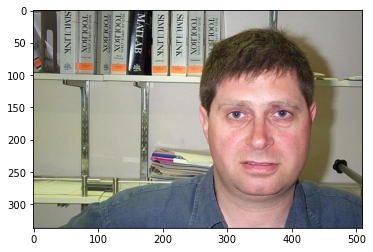

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Show the plots as a cell within the Jupyter Notebooks
%matplotlib inline       
plt.imshow(mpimg.imread(filenames[0]))

In [11]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

<ipython-input-11-b5a9da60004a>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
<ipython-input-11-b5a9da60004a>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
<ipython-input-11-b5a9da60004a>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
<ipython-input-11-b5a9da60004a>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(ima

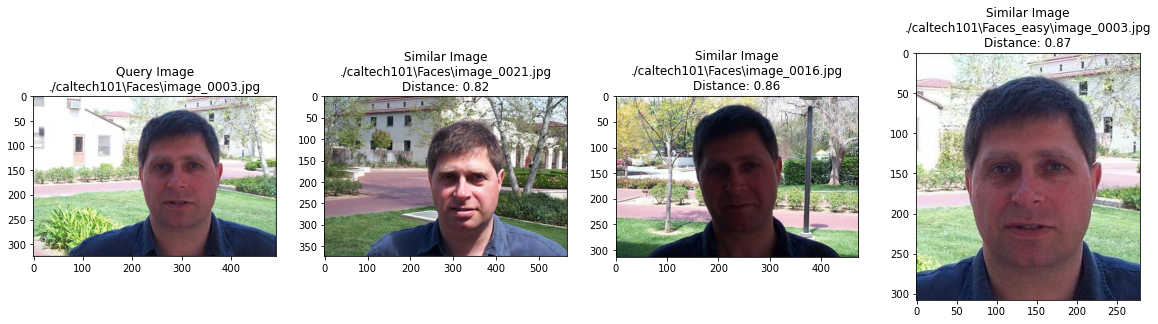

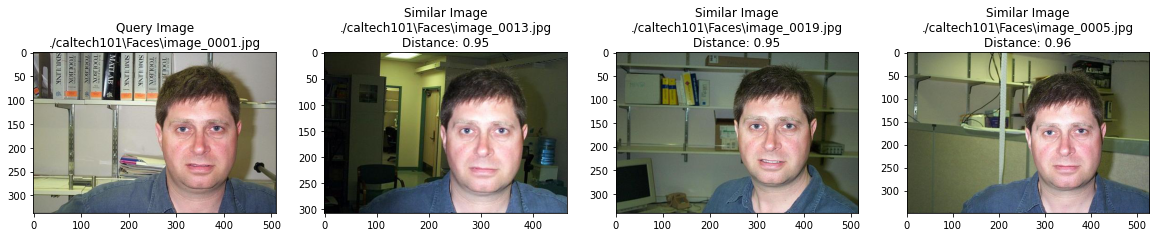

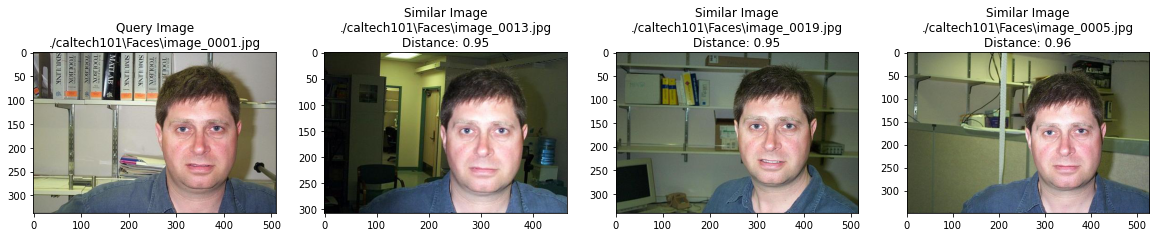

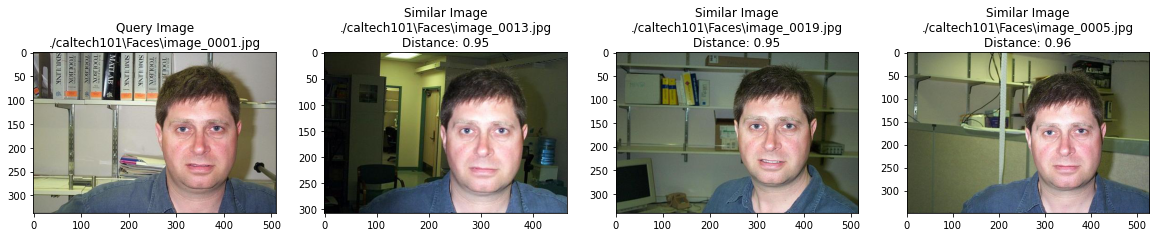

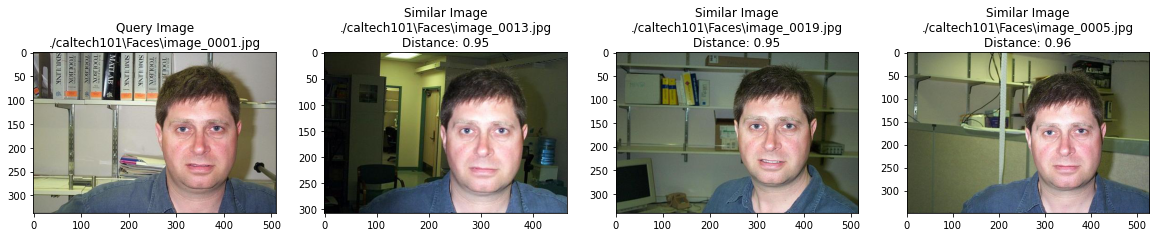

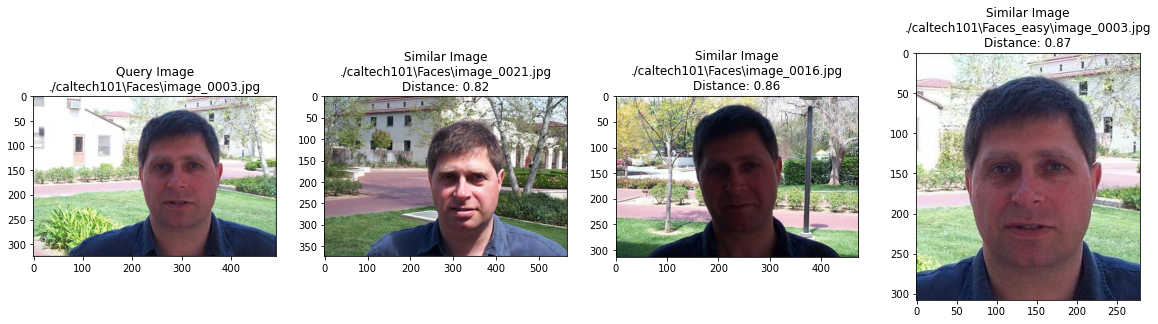

In [12]:
num_images = 6
for i in range(6):
    random_image_index = random.randint(0,num_images)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    # don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,4)]
    plot_images(similar_image_paths, distances[0])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.044s...
[t-SNE] Computed neighbors for 4000 samples in 1.868s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.147589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.040314
[t-SNE] KL divergence after 1000 iterations: 0.871124


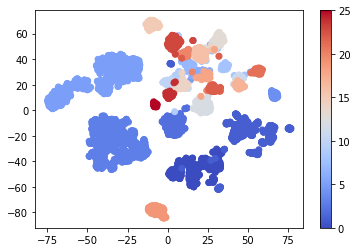

In [19]:
# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c =
               selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

In [20]:
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

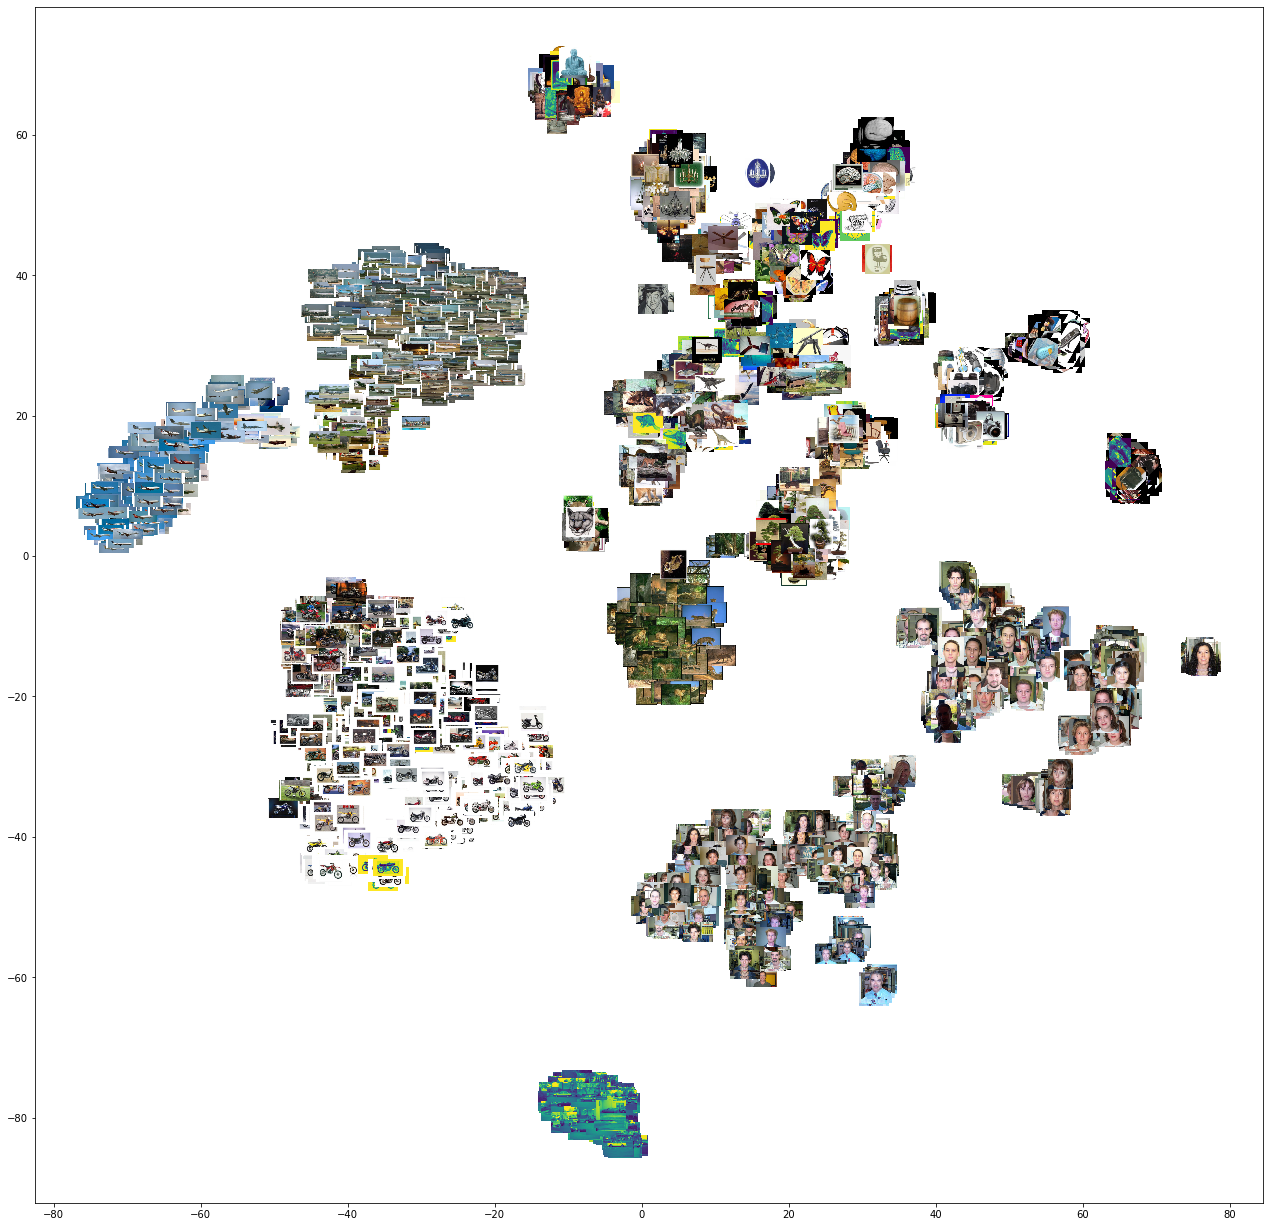

In [23]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

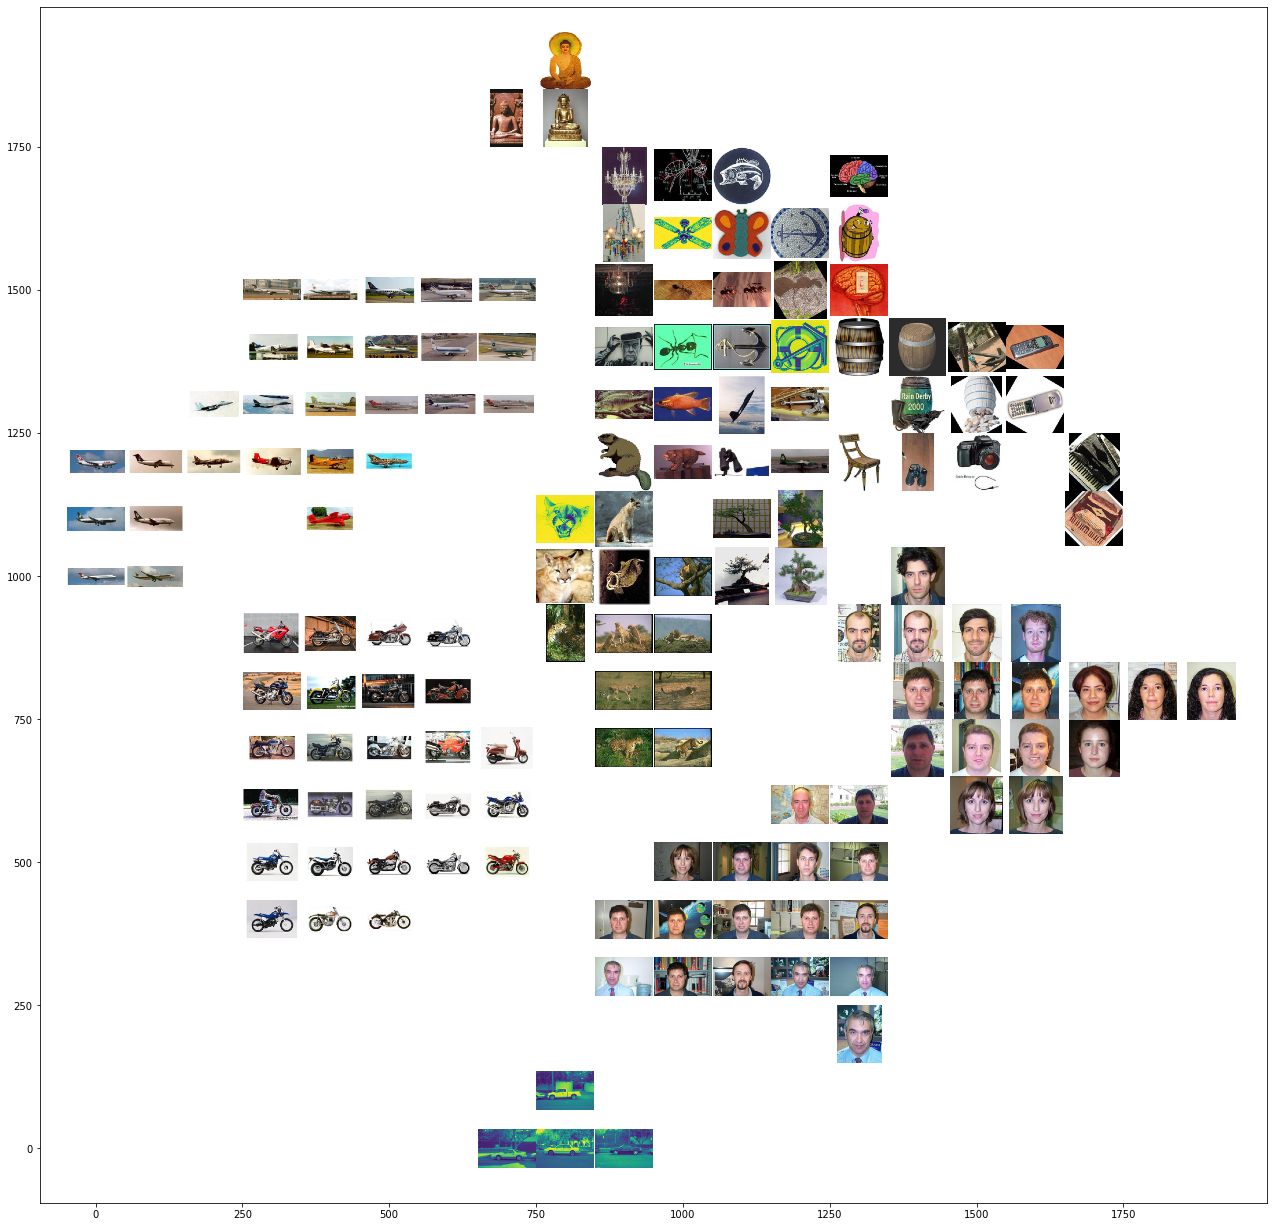

In [24]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)

### Reduction via PCA

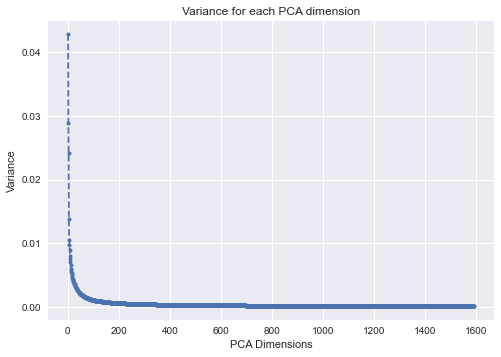

In [29]:
num_pca_comp = 200
pca = PCA(num_pca_comp)
pca.fit(feature_list)
matplotlib.style.use('seaborn')
plt.plot(range(1,num_pca_comp+1),pca.explained_variance_ratio_,'o--', markersize=4)
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

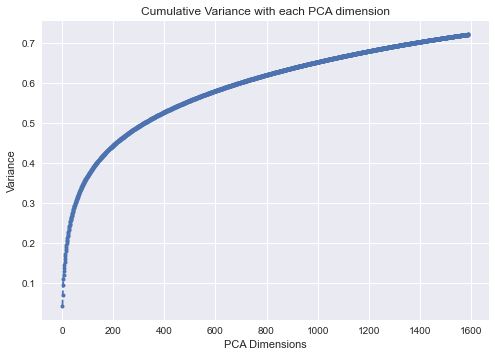

In [30]:
plt.plot(range(1,num_pca_comp+1),pca.explained_variance_ratio_.cumsum(),'o--', markersize=4)
plt.title ('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

In [36]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 10
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [37]:
pca_dimensions = [1,2]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    # Perform PCA
    pca = PCA(n_components = dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, time_taken = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(time_taken)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ",accuracy,"%",
",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  100.0 % ,	Time =  3.6850030422210693
For PCA Dimensions =  2 ,	Accuracy =  100.0 % ,	Time =  5.353923082351685


KeyboardInterrupt: 

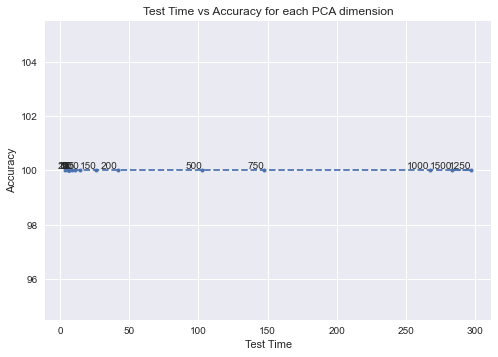

In [35]:
plt.plot(pca_time, pca_accuracy,'o--', markersize=4)
for label, x, y in zip(pca_dimensions, pca_time,pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title ('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()